<a href="https://colab.research.google.com/github/rmaffulli/MI_tutorial/blob/main/MI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Information Theory in neuroscience
Aims of the tutorial:
- Understand the concept of entropy and quantify entropy in a signal
- Binning strategies
- Define mutual information and calculate it for a Poisson spiking neuron
- Bias: origin, implications and mitigation strategies
- The effect of correlated firing on information transmission

---
# Setup

In [2]:
#@title Import
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
from scipy.stats import poisson

rnd.seed(2020)

In [3]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/rmaffulli/MI_tutorial/main/figures.mplstyle")

---
# Generation of Poisson spikes
We know that spikes are binary discrete events.
It is often assumed, in first approximation, that each spike is independent of the previous/following one. This implies that the probability of having a spike at a certain time is not influenced by the probability that a spike has occurred previously. This *model* (beware! this is a model the behaviour of a neuron) is consistent with a spike event to be drawn from a Poisson distribution.

*Food for toughts: what are the mechanisms that invalidate the Poisson assumption? Can we think of some reasons to doubt that a spiking neuron is Poissonian?*

In the cell below you can explore the function generating poissonian spike trains.

In [4]:
#@title Spike generation function
def poisson_spike(t,rate):
  # t: time points
  # rate: spiking rate in Hz
  dt = t[1] - t[0];
  sp = np.zeros_like(t)
  for i,tp in enumerate(t):
    if rnd.uniform(0,1) <= dt*rate:
      sp[i] = 1
  
  return sp

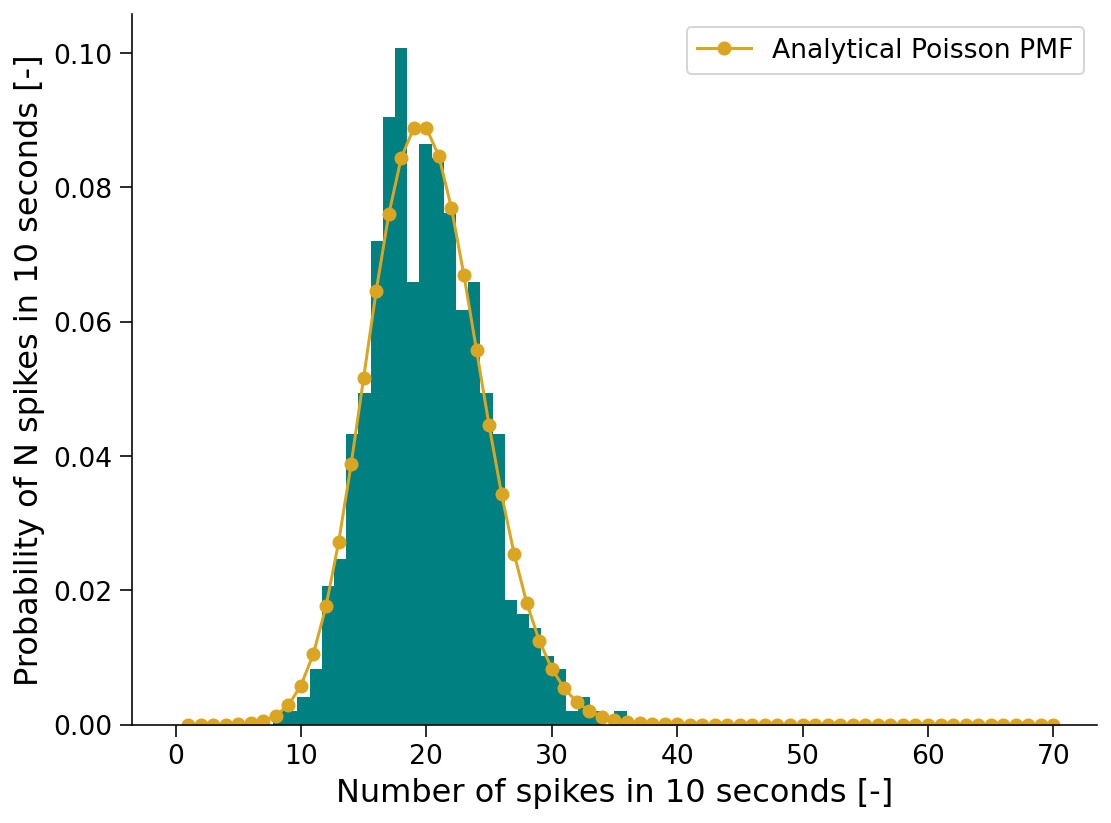

In [35]:
#@title The effect of the number of trials on estimation of probabiltiy mass function { run: "auto" }
trials = 500 #@param {type:"slider", min:1, max:1000, step:1}
rate = 2 #@param {type:"slider", min:0.0, max:10, step:0.5}

spike_cnt = np.zeros((trials,))

t = np.linspace(0,10,1000)
for tr in range(trials):
  sp = poisson_spike(t,rate)
  spike_cnt[tr-1] = sum(sp)

_ = plt.hist(spike_cnt,
             range=(0, 2*int(spike_cnt.max())),
             bins=2*int(spike_cnt.max() + 1),
             density=True, histtype='stepfilled',
             color='teal', edgecolor='none')
x_poisson = np.linspace(1,2*int(spike_cnt.max()),2*int(spike_cnt.max()))
_ = plt.plot(x_poisson, poisson.pmf(x_poisson, rate*10),
             '-o', label='Analytical Poisson PMF',
            color='goldenrod')
plt.xlabel('Number of spikes in 10 seconds [-]')
plt.ylabel('Probability of N spikes in 10 seconds [-]')
_ = plt.legend()

---
# Entropy of a random variable


---
# Conditional entropy of two random variables

---
# Mutual Information

---
# A digression on binning

---
# Bias and bias correction strategies